In [ ]:
from langchain.embeddings import OpenAIEmbeddings

# Initialize the embedding model using ChatOpenAI
embedding_model = OpenAIEmbeddings(model="text-embedding-ada-002")


# Generate embeddings for the document chunks
def embed_chunks(chunks):
    embeddings = embedding_model.embed_documents(chunks)
    return embeddings


# Embed the document chunks
chunks = ["CC(C)CC1=CC=C(C=C1)C(C)C(=O)O"]
embeddings = embed_chunks(chunks)
print(f"Number of embeddings: {len(embeddings)}")
print(embeddings[0])  # Preview the first embedding

# Data preparation

In [2]:
import pandas as pd
import numpy as np
import joblib

In [16]:
# Load pd_train
pd_train = pd.read_csv("data_smiles/Training_Group.csv")
pd_train["label"] = pd_train["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_train.shape)

(1241, 3)


In [17]:
pd_train["label"].value_counts()

label
1    683
0    558
Name: count, dtype: int64

In [18]:
# Load pd_test
pd_test = pd.read_csv("data_smiles/Testing_Group.csv")
pd_test["label"] = pd_test["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_test.shape)

(286, 3)


In [19]:
pd_test["label"].value_counts()

label
1    221
0     65
Name: count, dtype: int64

In [20]:
# Define the function to embed SMILES strings
def embed_smiles(smiles_list):
    embeddings = embedding_model.embed_documents(smiles_list)
    return embeddings


# Apply embedding to each SMILES string
pd_train["Embeddings"] = embed_smiles(pd_train["Smiles"].tolist())
print(f"Generated {len(pd_train['Embeddings'])} embeddings.")
print("Preview of first embedding:", pd_train["Embeddings"][0])

# Save the embeddings
joblib.dump(pd_train, "data_smiles/Training_Group_openai_embeddings.pkl")

Generated 1241 embeddings.
Preview of first embedding: [-0.004447528443423119, 0.0031313571253721558, -0.005364810826750572, -0.002672715933708429, -0.013371654234931194, 0.023138775467664952, -0.015077024076716274, -0.0254513610838092, 0.0023271198356445326, -0.013197240806960168, 0.012745059501238313, 0.02046444368935618, 0.003371982230564002, 0.026975857844512015, -0.012829035923006939, 0.002089724557008305, 0.018397328616729106, 0.0028891171069025004, -0.0001787530126400414, -0.0021527071061654087, -0.014870312383189059, -0.0030328460184419767, -0.0005450402161797007, -0.01165982380871234, 0.00872710311198645, 0.022841627699257874, 0.008940274458624902, -0.023797667535591486, 0.011272239965425397, -0.018461925147841483, -0.0009778425625678424, 0.00437001167476573, -0.035218483247865494, -0.02211813723757389, -0.01833273208561673, 0.007564351116464356, -0.022182733768686267, -0.016420648687659363, 0.001484124394418849, -0.02206645815003892, 0.009153445805263354, 0.022299009387333618

['data_smiles/Training_Group_openai_embeddings.pkl']

In [21]:
pd_test["Embeddings"] = embed_smiles(pd_test["Smiles"].tolist())
joblib.dump(pd_test, "data_smiles/Testing_Group_openai_embeddings.pkl")

['data_smiles/Testing_Group_openai_embeddings.pkl']

In [3]:
# load the embeddings
pd_train = joblib.load("data_smiles/Training_Group_openai_embeddings.pkl")
pd_test = joblib.load("data_smiles/Testing_Group_openai_embeddings.pkl")

In [4]:
# Prepare features and labels for the split
X_train = np.vstack(pd_train["Embeddings"].values)  # Stack embeddings into a 2D array
y_train = pd_train["label"].values

print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)

X_train Shape: (1241, 1536)
y_train Shape: (1241,)


In [5]:
X_test = np.vstack(pd_test["Embeddings"].values)  # Stack embeddings into a 2D array
y_test = pd_test["label"].values

print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)

X_test Shape: (286, 1536)
y_test Shape: (286,)


# Model training

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def compute_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)

    return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()


def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = sigmoid(dot_product)

    return y_hat


def compute_gradient(X, y, y_hat):
    return np.dot(X.T, (y_hat - y)) / y.size


def update_theta(theta, gradient, lr):
    return theta - lr * gradient


def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta).round()
    acc = (y_hat == y).mean()

    return acc

In [16]:
# lr = 0.01
# epochs = 200
# batch_size = 128
random_state = 2

lr = 0.08759865074680719
epochs = 271
batch_size = 32

np.random.seed(random_state)
theta = np.random.uniform(size=X_train.shape[1])

In [17]:
train_accs = []
train_losses = []
test_accs = []
test_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    test_batch_losses = []
    test_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i : i + batch_size]
        y_i = y_train[i : i + batch_size]

        y_hat = predict(X_i, theta)

        train_loss = compute_loss(y_hat, y_i)

        gradient = compute_gradient(X_i, y_i, y_hat)

        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)

        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)

        y_test_hat = predict(X_test, theta)
        test_loss = compute_loss(y_test_hat, y_test)
        test_batch_losses.append(test_loss)

        test_acc = compute_accuracy(X_test, y_test, theta)
        test_batch_accs.append(test_acc)

    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    test_batch_loss = sum(test_batch_losses) / len(test_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    test_batch_acc = sum(test_batch_accs) / len(test_batch_accs)

    train_losses.append(train_batch_loss)
    test_losses.append(test_batch_loss)
    train_accs.append(train_batch_acc)
    test_accs.append(test_batch_acc)

    print(
        f"\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\ttestidation loss: {test_batch_loss:.3f}"
    )


EPOCH 1:	Training loss: 0.705	testidation loss: 0.745

EPOCH 2:	Training loss: 0.694	testidation loss: 0.695

EPOCH 3:	Training loss: 0.692	testidation loss: 0.675

EPOCH 4:	Training loss: 0.691	testidation loss: 0.666

EPOCH 5:	Training loss: 0.691	testidation loss: 0.662

EPOCH 6:	Training loss: 0.690	testidation loss: 0.660

EPOCH 7:	Training loss: 0.690	testidation loss: 0.659

EPOCH 8:	Training loss: 0.690	testidation loss: 0.659

EPOCH 9:	Training loss: 0.690	testidation loss: 0.658

EPOCH 10:	Training loss: 0.690	testidation loss: 0.658

EPOCH 11:	Training loss: 0.689	testidation loss: 0.658

EPOCH 12:	Training loss: 0.689	testidation loss: 0.658

EPOCH 13:	Training loss: 0.689	testidation loss: 0.658

EPOCH 14:	Training loss: 0.689	testidation loss: 0.658

EPOCH 15:	Training loss: 0.688	testidation loss: 0.658

EPOCH 16:	Training loss: 0.688	testidation loss: 0.658

EPOCH 17:	Training loss: 0.688	testidation loss: 0.658

EPOCH 18:	Training loss: 0.688	testidation loss: 0.658



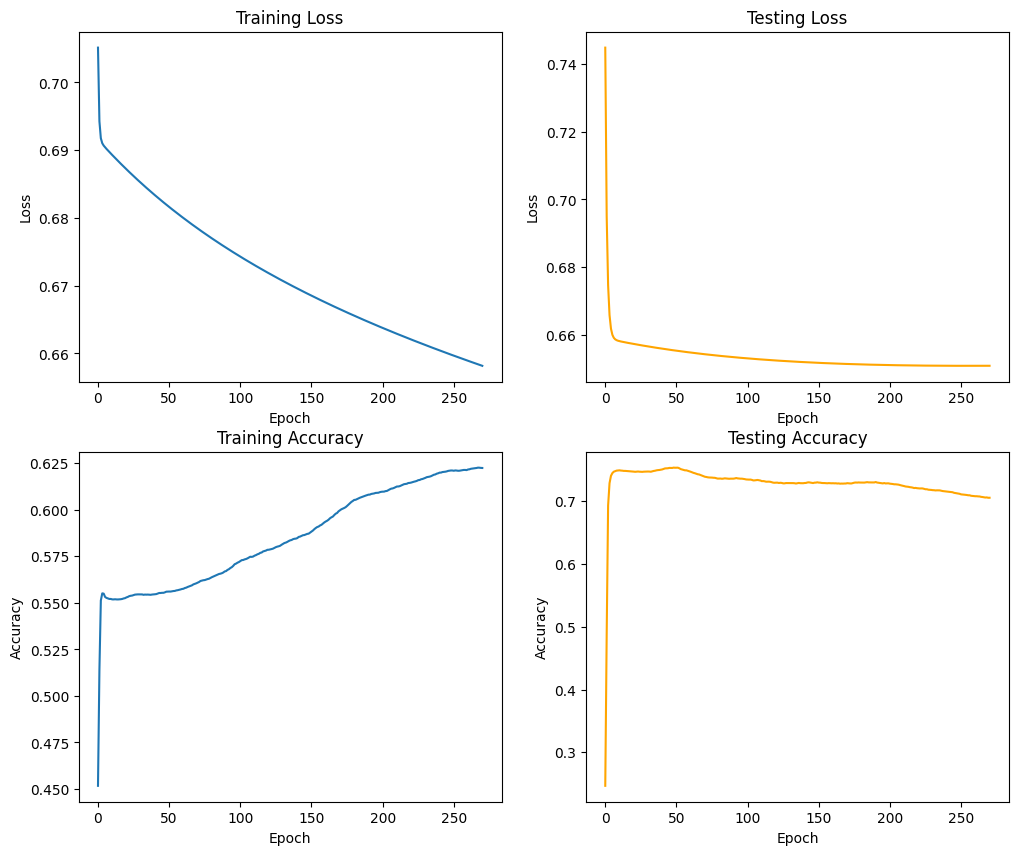

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
ax[0, 0].set_title("Training Loss")

ax[0, 1].plot(test_losses, "orange")
ax[0, 1].set(xlabel="Epoch", ylabel="Loss")
ax[0, 1].set_title("Testing Loss")

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 0].set_title("Training Accuracy")

ax[1, 1].plot(test_accs, "orange")
ax[1, 1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 1].set_title("Testing Accuracy")

plt.show()

In [19]:
test_set_acc = compute_accuracy(X_test, y_test, theta)
print("Evaluation on validation and test set:")
print(f"Accuracy: {test_set_acc}")

Evaluation on validation and test set:
Accuracy: 0.7027972027972028


In [20]:
# compute auc, precision, recall
from sklearn.metrics import roc_auc_score, precision_score, recall_score

y_test_hat = predict(X_test, theta)
auc = roc_auc_score(y_test, y_test_hat)
precision = precision_score(y_test, y_test_hat.round())
recall = recall_score(y_test, y_test_hat.round())

print(f"AUC: {auc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

AUC: 0.655
Precision: 0.843
Recall: 0.756


# Model optuna

In [11]:
import optuna

In [12]:
# Optuna Objective function to optimize AUC
def objective(trial):
    # Define hyperparameters to tune
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    epochs = trial.suggest_int("epochs", 50, 500)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])

    # Initialize parameters
    theta = np.random.uniform(size=X_train.shape[1])
    train_losses = []
    test_losses = []
    test_aucs = []

    # Training loop
    for epoch in range(epochs):
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i : i + batch_size]
            y_batch = y_train[i : i + batch_size]

            # Forward pass and loss
            y_hat = predict(X_batch, theta)
            train_loss = compute_loss(y_hat, y_batch)
            gradient = compute_gradient(X_batch, y_batch, y_hat)
            theta = update_theta(theta, gradient, lr)

        # Calculate AUC on test data
        y_test_hat = predict(X_test, theta)
        test_auc = roc_auc_score(y_test, y_test_hat)
        test_aucs.append(test_auc)

        # Stop early if AUC is satisfactory
        trial.report(test_auc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return max(test_aucs)

In [13]:
# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-11-11 21:59:27,935] A new study created in memory with name: no-name-54c82b00-ea2c-4c04-aae5-820b2707dedb
/var/folders/y2/hzjfncr92llg100m08nwxmhc0000gn/T/ipykernel_15887/2620807037.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2024-11-11 21:59:31,350] Trial 0 finished with value: 0.5175078315349808 and parameters: {'lr': 0.0003727739856485676, 'epochs': 415, 'batch_size': 64}. Best is trial 0 with value: 0.5175078315349808.
/var/folders/y2/hzjfncr92llg100m08nwxmhc0000gn/T/ipykernel_15887/2620807037.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2024-

In [15]:
# Display best trial
print("Best trial:")
trial = study.best_trial
print(f"  AUC Score: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  AUC Score: 0.6825617821092935
  Params:
    lr: 0.08759865074680719
    epochs: 271
    batch_size: 32


# Model training

In [5]:
from tpot import TPOTClassifier

# Set up TPOT with basic configuration
tpot = TPOTClassifier(
    generations=10,
    population_size=40,
    verbosity=2,
    scoring="roc_auc",  # AUC
    random_state=42,
    n_jobs=6,  # Use 4 cores
)

# Fit the model
tpot.fit(X_train, y_train)

                                                                               
Generation 1 - Current best internal CV score: 0.6624602914997129
                                                                               
Generation 2 - Current best internal CV score: 0.6624602914997129
                                                                              
Generation 3 - Current best internal CV score: 0.6624602914997129
                                                                                
Generation 4 - Current best internal CV score: 0.6624602914997129
                                                                                
Generation 5 - Current best internal CV score: 0.6624602914997129
                                                                              
Generation 6 - Current best internal CV score: 0.6624602914997129
                                                                              
Generation 7 - Current best internal CV score

TPOTClassifier(generations=10, n_jobs=6, population_size=40, random_state=42,
               scoring='roc_auc', verbosity=2)

In [6]:
# Access the best pipeline directly after fitting
from pprint import pprint
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
)


best_pipeline = tpot.fitted_pipeline_

#
y_pred = best_pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)

y_pred = (y_pred > 0.5).astype(int)  # Binarize predictions for threshold of 0.5
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)  # Same as sensitivity for positive class

# Calculate sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Extract model name and parameters
model_name = type(best_pipeline.steps[-1][1]).__name__  # Name of the final estimator
model_params = best_pipeline.steps[-1][1].get_params()  # Params of the final estimator

# Append results to list
result = {
    "Best model": best_pipeline,
    "Model Name": model_name,
    "Parameters": model_params,
    "AUC": auc,
    "Precision": precision,
    "Recall": recall,
    "Sensitivity": sensitivity,
    "Specificity": specificity,
}

pprint(result)

{'AUC': 0.6008353637312913,
 'Best model': Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features=0.7500000000000001,
                                        min_samples_leaf=8, min_samples_split=4,
                                        random_state=42))]),
 'Model Name': 'RandomForestClassifier',
 'Parameters': {'bootstrap': True,
                'ccp_alpha': 0.0,
                'class_weight': None,
                'criterion': 'gini',
                'max_depth': None,
                'max_features': 0.7500000000000001,
                'max_leaf_nodes': None,
                'max_samples': None,
                'min_impurity_decrease': 0.0,
                'min_samples_leaf': 8,
                'min_samples_split': 4,
                'min_weight_fraction_leaf': 0.0,
                'monotonic_cst': None,
                'n_estimators': 100,
                'n_jobs': None,
                'o

# MLP

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

c:\Users\predator\anaconda3\envs\dili-3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
# Split data into train and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_split, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_split, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val_split, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_split, dtype=torch.float32).unsqueeze(1)

# Create PyTorch datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))


Train dataset size: 1116
Validation dataset size: 125


In [9]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(MLP, self).__init__()
        layers = []
        for i in range(num_layers):
            if i == 0:
                layers.append(nn.Linear(input_dim, hidden_dim))
            else:
                layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden_dim, 1))  # Output layer for binary classification
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [12]:
# Training function
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = torch.sigmoid(model(X_batch))
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())
    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)
    auc = roc_auc_score(y_true, y_pred)
    return auc

In [24]:
# Define the Optuna objective function
def objective(trial):
    # Suggest hyperparameters
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256, step=32)
    num_layers = trial.suggest_int("num_layers", 1, 5)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

    # Create model, optimizer, and criterion
    model = MLP(input_dim=X_train.shape[1], hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # Adjust DataLoader batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(200):  # Limit epochs for faster tuning
        train_loss = train(model, train_loader, criterion, optimizer)

    # Evaluate the model on validation set
    auc = evaluate(model, val_loader)

    # Store metrics for later analysis
    trial.set_user_attr("AUC", auc)
    trial.set_user_attr("Train Loss", train_loss)

    return auc


In [ ]:

# Create Optuna study and optimize (21min)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

In [26]:
# Print best trial
print("Best trial:")
trial = study.best_trial
print(f"AUC: {trial.value}")
print("Best Hyperparameters:")
for key, value in trial.params.items():
    print(f"  {key}: {value}")

Best trial:
AUC: 0.7270800211976682
Best Hyperparameters:
  hidden_dim: 64
  num_layers: 1
  dropout: 0.23188179158539773
  lr: 0.00014122738845363748
  batch_size: 128


In [27]:
# Train the best model
best_params = trial.params
best_model = MLP(input_dim=X_train.shape[1], hidden_dim=best_params["hidden_dim"],
                 num_layers=best_params["num_layers"], dropout=best_params["dropout"]).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=best_params["lr"])
criterion = nn.BCEWithLogitsLoss()
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)

for epoch in range(10):  # Retrain for a set number of epochs
    train_loss = train(best_model, train_loader, criterion, optimizer)

In [28]:
# Evaluate the best model on the validation set
best_auc = evaluate(best_model, val_loader)
print(f"Best Model Validation AUC: {best_auc:.4f}")


Best Model Validation AUC: 0.6762


In [29]:
# evaluate on test set
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_auc = evaluate(best_model, test_loader)
print(f"Best Model Test AUC: {test_auc:.4f}")

Best Model Test AUC: 0.6798
